# Experiments - Part 2
## Based on Luz Rello, et al., (2020) **Predicting risk of dyslexia with an online gamified test**

* Program name: Master's in Computer Science - Artificial Intelligence (MAI)
* Student name: Kostadin Georgiev
* Student Id: 22229358

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, backend as K
from imblearn.over_sampling import SMOTE, ADASYN

import csv
import time

%matplotlib inline

## Experiments

In [2]:
# Exctract name of columns
features = pd.read_csv('data/Dyt-desktop.csv', delimiter=';').columns.values[:-1]

def load_data(path):
    data = pd.read_csv(path, delimiter=';')

    # Extract data points (features) as a NumPy array
    X = data.iloc[:, :-1].values

    # Extract labels as a NumPy array
    y = data['Dyslexia'].values
    y = np.where(y == 'Yes', 1, 0)

    return X, y

def pre_process(data, labels):
    X, y = data, labels

    # Replace NaN values with 0s
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = np.nan_to_num(X[i][j])

    # Encode 'Male' to 0 and 'Female' to 1
    X[:, 0] = np.where(X[:, 0] == 'Male', 0, 1)

    # Encode 'Yes' to 1 and 'No' to 0
    X[:, 1] = np.where(X[:, 1] == 'Yes', 1, 0)
    X[:, 2] = np.where(X[:, 2] == 'Yes', 1, 0)

    # Perform Min-Max scaling for non-'Accuracy' columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i, feature in enumerate(features):
        if not feature.startswith('Accuracy'):
            column_values = X[:, i].astype(float).reshape(-1, 1)
            X[:, i] = scaler.fit_transform(column_values).flatten()
    
    return X, y

In [3]:
data, labels = load_data('data/Dyt-desktop.csv')
data, labels = pre_process(data, labels)

### Experiment 8: Neural Network with SMOTE

In [4]:
def create_network(n_features=None, dense_units=(64,)):
    # Input layer
    inputs = layers.Input((n_features,), name="input")
    x = inputs

    # Fully-connected layers for classification
    for i, units in enumerate(dense_units):
        name = "dense_" + str(i+1)
        x = layers.Dense(units, activation='relu', name=name)(x)

    # Output layer with 2 units for the 2 classes
    outputs = layers.Dense(1, activation='sigmoid', name="output")(x)

    model = models.Model(inputs, outputs)

    return model

def pre_process_network(data, labels, test_size=0.1, oversampling=None, seed=42):
    X, y = pre_process(data, labels, rescale=True)
    X = np.asarray(X).astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    if oversampling == 'smote':
        oversampler = SMOTE(random_state=seed)
    if oversampling == 'adasyn':
        oversampler = ADASYN(random_state=seed)
    if oversampling is not None:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

def train_network(X, y, dense_units=(64,), optimizer='sgd', lr=0.001, batch_size=32, epochs=1, seed=42):
    tf.keras.utils.set_random_seed(seed)

    if optimizer == 'sgd': 
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'adam': 
        opt = keras.optimizers.Adam(learning_rate=lr)

    model = create_network(n_features=X.shape[1], dense_units=dense_units)
    model.compile(optimizer=opt, loss="binary_crossentropy")
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

    return model, history

def plot_history(history):
    epochs = len(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.xlim(0, epochs - 1)
    plt.xticks(np.arange(0, epochs, epochs / 10))
    #plt.ylim(0, 1)
    #plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

def evaluate_network(model, X_test, y_test):
    predicted_probabilities = model.predict(X_test, verbose=0)
    y_pred = (predicted_probabilities[:, 0] >= 0.5).astype(int)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    precision = metrics.precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    roc_score = metrics.roc_auc_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)

    return accuracy, recall, precision, roc_score, f1_score

In [17]:
X_train, X_test, y_train, y_test = pre_process_network(data, labels, test_size=0.1, oversampling='smote', seed=42)

hidden_layers = [
    (128,), (64,), (32,), (16,), (8,), (4,), (2,),
    (128, 64), (64, 32), (32, 16), (16, 8), (8, 4), (4, 2),
    (128, 64, 32), (64, 32, 16), (32, 16, 8), (16, 8, 4), (8, 4, 2),
    (128, 64, 32, 16), (64, 32, 16, 8), (32, 16, 8, 4), (16, 8, 4, 2),
    (128, 64, 32, 16, 8), (64, 32, 16, 8, 4), (32, 16, 8, 4, 2),
    (128, 64, 32, 16, 8, 4), (64, 32, 16, 8, 4, 2),
    (128, 64, 32, 16, 8, 4, 2)
]
optimizers = ['sgd', 'adam']
learning_rates = [0.001, 0.0001]
batch_sizes = [8, 16, 32]

results = pd.DataFrame(columns=['Hidden Units', 'Optimizer', 'Learning Rate', 'Batch Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'F1 Score'])
i = 0
total_configs = len(hidden_layers) * len(optimizers) * len(learning_rates) * len(batch_sizes)
times_history = []

f = open('./results/hyperparameter_tuning.csv', "w+")
f.close()

with open('./results/hyperparameter_tuning.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Hidden Units', 'Optimizer', 'Learning Rate', 'Batch Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'F1 Score'])

for units in hidden_layers:
    for opt in optimizers:
        for lr in learning_rates:
            for batch in batch_sizes:
                start_time = time.time()

                model, history = train_network(X_train, y_train, dense_units=units, optimizer=opt, lr=lr, batch_size=batch, epochs=1000, seed=42)
                accuracy, recall, precision, roc_score, f1_score = evaluate_network(model, X_test, y_test)
                accuracy = float("{:.1f}".format(accuracy * 100))
                recall = float("{:.1f}".format(recall * 100))
                precision = float("{:.1f}".format(precision * 100))
                roc_score = float("{:.3f}".format(roc_score))
                f1_score = float("{:.1f}".format(f1_score * 100))
                results.loc[i] = [units, opt, lr, batch, accuracy, recall, precision, roc_score, f1_score]
                
                with open('./results/hyperparameter_tuning.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([units, opt, lr, batch, accuracy, recall, precision, roc_score, f1_score])

                i = i + 1
                elapsed_time = time.time() - start_time
                times_history.append(elapsed_time)
                float("{:.1f}".format(accuracy * 100))
                print(f'Finished configuration {i} in {round(elapsed_time / 60, 2)} min')
                print(f'Approx. time remaining: {round(((total_configs - i) * np.mean(times_history)) / 60, 2)} min')
                print()

results

Finished configuration 1 in 10.71 min
Approx. time remaining: 3586.38 min

Finished configuration 2 in 5.62 min
Approx. time remaining: 2725.77 min

Finished configuration 3 in 3.18 min
Approx. time remaining: 2165.09 min

Finished configuration 4 in 10.69 min
Approx. time remaining: 2506.3 min

Finished configuration 5 in 5.65 min
Approx. time remaining: 2373.28 min

Finished configuration 6 in 3.17 min
Approx. time remaining: 2145.99 min

Finished configuration 7 in 12.09 min
Approx. time remaining: 2401.87 min

Finished configuration 8 in 6.37 min
Approx. time remaining: 2356.37 min

Finished configuration 9 in 3.53 min
Approx. time remaining: 2216.26 min

Finished configuration 10 in 12.1 min
Approx. time remaining: 2382.97 min

Finished configuration 11 in 6.32 min
Approx. time remaining: 2346.31 min

Finished configuration 12 in 3.61 min
Approx. time remaining: 2241.7 min

Finished configuration 13 in 10.55 min
Approx. time remaining: 2325.05 min

Finished configuration 14 in 5.5

,Hidden Units,Optimizer,Learning Rate,Batch Size,Accuracy,Recall,Precision,ROC,F1 Score
0,"(128,)",sgd,0.0010,8,78.1,57.1,32.2,0.692,41.2
1,"(128,)",sgd,0.0010,16,78.9,57.1,33.3,0.697,42.1
2,"(128,)",sgd,0.0010,32,76.2,51.0,28.4,0.655,36.5
3,"(128,)",sgd,0.0001,8,78.6,46.9,30.7,0.652,37.1
4,"(128,)",sgd,0.0001,16,78.9,42.9,30.0,0.637,35.3
...,...,...,...,...,...,...,...,...,...
331,"(128, 64, 32, 16, 8, 4, 2)",adam,0.0010,16,82.5,46.9,37.7,0.675,41.8
332,"(128, 64, 32, 16, 8, 4, 2)",adam,0.0010,32,86.3,40.8,48.8,0.671,44.4
333,"(128, 64, 32, 16, 8, 4, 2)",adam,0.0001,8,83.3,36.7,37.5,0.636,37.1
334,"(128, 64, 32, 16, 8, 4, 2)",adam,0.0001,16,82.7,34.7,35.4,0.624,35.1


In [23]:
results.sort_values(by="F1 Score", ascending=False).head(10)

,Hidden Units,Optimizer,Learning Rate,Batch Size,Accuracy,Recall,Precision,ROC,F1 Score
82,"(2,)",adam,0.0001,16,87.1,69.4,51.5,0.796,59.1
81,"(2,)",adam,0.0001,8,86.8,69.4,50.7,0.795,58.6
83,"(2,)",adam,0.0001,32,86.3,69.4,49.3,0.792,57.6
22,"(64,)",adam,0.0001,16,87.1,63.3,51.7,0.770,56.9
69,"(4,)",adam,0.0001,8,84.9,71.4,46.1,0.792,56.0
79,"(2,)",adam,0.0010,16,86.0,65.3,48.5,0.773,55.7
70,"(4,)",adam,0.0001,16,84.7,71.4,45.5,0.791,55.6
80,"(2,)",adam,0.0010,32,85.5,67.3,47.1,0.778,55.5
78,"(2,)",adam,0.0010,8,86.3,63.3,49.2,0.766,55.4
59,"(8,)",adam,0.0001,32,84.9,67.3,45.8,0.775,54.5


In [36]:
def cross_validate_neural_network(data, labels, n_folds=10, threshold=0.5, seed=42, oversampling=None, dense_units=(64,), optimizer='sgd', lr=0.001, batch_size=32, epochs=1):
    X, y = pre_process(data, labels, rescale=True)
    X = np.asarray(X).astype('float32')

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    accuracies = []
    recalls = []
    precisions = []
    rocs = []
    f1_scores = []
    
    for train, test in kf.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        if oversampling == 'smote':
            oversampler = SMOTE(random_state=seed)
        if oversampling == 'adasyn':
            oversampler = ADASYN(random_state=seed)
        if oversampling is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        model = train_network(X_train, y_train, dense_units=dense_units, optimizer=optimizer, lr=lr, batch_size=batch_size, epochs=epochs, seed=seed)
        predicted_probabilities = model[0].predict(X_test, verbose=0)
        y_pred = (predicted_probabilities[:, 0] >= threshold).astype(int)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        precision = metrics.precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        roc_score = metrics.roc_auc_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
        
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        rocs.append(roc_score)
        f1_scores.append(f1_score)
    
    accuracy = float("{:.1f}".format(np.mean(accuracies) * 100))
    recall = float("{:.1f}".format(np.mean(recalls) * 100))
    precision = float("{:.1f}".format(np.mean(precisions) * 100))
    roc = float("{:.3f}".format(np.mean(rocs)))
    f1_score = float("{:.1f}".format(np.mean(f1_scores) * 100))

    return accuracy, recall, precision, roc, f1_score

In [37]:
accuracy, recall, precision, roc, f1_score = cross_validate_neural_network(data, labels, n_folds=10, threshold=0.5, seed=42, oversampling='smote', dense_units=(2,), optimizer='adam', lr=0.0001, batch_size=16, epochs=1000)

In [42]:
result_exp_05 = pd.DataFrame(columns=['Dataset', 'Size', 'Accuracy', 'Recall', 'Precision', 'ROC', 'F1 Score', 'Threshold'])
result_exp_05.loc[0] = ['A1 (7-17)', 3644, accuracy, recall, precision, roc, f1_score, "{:.3f}".format(0.5)]
result_exp_05

,Dataset,Size,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,A1 (7-17),3644,85.2,61.0,38.2,0.745,46.7,0.500


### Experiment 09: Neural Network with SMOTE and Optimised Trheshold

In [246]:
def cross_validate_neural_network_optimise_threshold(data, labels, n_folds=10, seed=42, oversampling=None, dense_units=(64,), optimizer='sgd', lr=0.001, batch_size=32, epochs=1):
    X, y = pre_process(data, labels, rescale=True)
    X = np.asarray(X).astype('float32')

    df = pd.DataFrame(columns=['Dataset', 'Size','Accuracy', 'Recall', 'Precision', 'ROC', 'F1 Score', 'Threshold'])
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    i = 0
    
    for train, test in kf.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        if oversampling == 'smote':
            oversampler = SMOTE(random_state=seed)
        if oversampling == 'adasyn':
            oversampler = ADASYN(random_state=seed)
        if oversampling is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        model = train_network(X_train, y_train, dense_units=dense_units, optimizer=optimizer, lr=lr, batch_size=batch_size, epochs=epochs, seed=seed)

        for j, t in enumerate(np.arange(0.300, 0.805, 0.005)):
            predicted_probabilities = model[0].predict(X_test, verbose=0)
            y_pred = (predicted_probabilities[:, 0] >= t).astype(int)

            accuracy = metrics.accuracy_score(y_test, y_pred)
            recall = metrics.recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
            precision = metrics.precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
            roc_score = metrics.roc_auc_score(y_test, y_pred)
            f1_score = metrics.f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)

            df.loc[i] = ['A1 (7-17)', 3644, "{:.1f}".format(accuracy * 100), "{:.1f}".format(recall * 100), "{:.1f}".format(precision * 100), "{:.3f}".format(roc_score), "{:.1f}".format(f1_score * 100), "{:.3f}".format(t)]

            i = i + 1

    df = df.astype({'Accuracy': 'float', 'Recall': 'float', 'Precision': 'float', 'ROC': 'float', 'F1 Score': 'float'})
    df.groupby(['Dataset', 'Size', 'Threshold']).mean(numeric_only=True).reset_index()

    return df

In [247]:
df = cross_validate_neural_network_optimise_threshold(data, labels, n_folds=10, seed=42, oversampling='smote', dense_units=(2,), optimizer='adam', lr=0.0001, batch_size=16, epochs=1000)
df.to_csv('./results/neural_network_threshold_optimisation.csv')

In [248]:
df.sort_values('F1 Score', ascending=False)

,Dataset,Size,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
61,A1 (7-17),3644,89.3,63.3,59.6,0.783,61.4,0.605
60,A1 (7-17),3644,89.0,63.3,58.5,0.782,60.8,0.600
58,A1 (7-17),3644,88.5,65.3,56.1,0.787,60.4,0.590
74,A1 (7-17),3644,89.9,57.1,63.6,0.760,60.2,0.670
67,A1 (7-17),3644,89.0,61.2,58.8,0.773,60.0,0.635
...,...,...,...,...,...,...,...,...
816,A1 (7-17),3644,68.1,78.1,18.7,0.726,30.1,0.300
822,A1 (7-17),3644,69.2,75.0,18.8,0.718,30.0,0.330
821,A1 (7-17),3644,69.0,75.0,18.6,0.717,29.8,0.325
820,A1 (7-17),3644,68.4,75.0,18.3,0.714,29.4,0.320


In [24]:
results_1 = pd.read_csv('./results/results_1.csv', index_col=[0])
results_2 = pd.DataFrame({
    'Experiment': ['EXP08: NN with SMOTE', 'EXP09: NN with SMOTE and Optimised Threshold'],
    'Accuracy': [85.2, 89.3],
    'Recall': [61.0, 63.3],
    'Precision': [38.2, 59.6],
    'ROC': [0.745, 0.783],
    'F1 Score': [46.7, 61.4],
    'Threshold': [0.5, 0.605]
})
results_3 = pd.concat([results_1, results_2], ignore_index = True)
results_3.to_csv('./results/results_2.csv')
results_3

,Experiment,Accuracy,Recall,Precision,ROC,F1 Score,Threshold
0,EXP01: Baseline Model,76.8,80.0,29.1,0.782,42.4,0.115
1,EXP02: Random Forest w/o Class Balancing,90.0,10.2,75.0,0.549,17.7,0.500
2,EXP03: Random Forest with Class Balancing,89.6,4.6,75.8,0.522,8.6,0.500
3,EXP04: Random Forest with SMOTE,90.8,24.4,70.9,0.616,36.0,0.500
4,EXP05: Random Forest with ADASYN,90.7,25.0,69.5,0.618,36.1,0.500
5,EXP06: K-Nearest Neighbors with SMOTE,80.8,34.7,23.4,0.605,27.7,0.500
6,EXP07: Support Vector Machine with SMOTE,86.2,49.9,39.2,0.702,43.8,0.500
7,EXP08: NN with SMOTE,85.2,61.0,38.2,0.745,46.7,0.500
8,EXP09: NN with SMOTE and Optimised Threshold,89.3,63.3,59.6,0.783,61.4,0.605


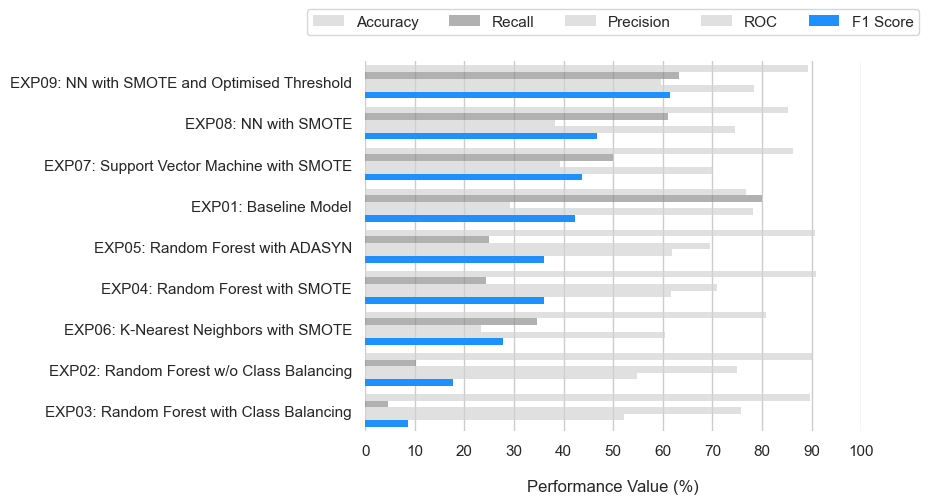

In [22]:
results_sorted = results_3.sort_values(by='F1 Score', ascending=False)
results_sorted['ROC'] = results_sorted['ROC'].apply(lambda x: x*100)
results_sorted = results_sorted.drop('Threshold', axis=1)
melted_df = pd.melt(results_sorted, id_vars='Experiment', var_name='Metric', value_name='Value')
ax = sns.barplot(data=melted_df, x='Value', y='Experiment', hue='Metric', dodge=True, linewidth=0)

sns.set(style='whitegrid')
#plt.figure(figsize=(10, 6))
colors = {'Accuracy': 'lightgrey', 'Recall': '#909090', 'Precision': 'lightgrey', 'ROC': 'lightgrey', 'F1 Score': 'dodgerblue'}

for metric, color in colors.items():
    for bar in ax.containers:
        if metric in bar.get_label():
            for rect in bar:
                alpha = 0.7 if metric != 'F1 Score' else 1.0
                for rect in bar:
                    rect.set_color(color)
                    rect.set_alpha(alpha)

plt.xlabel('Performance Value (%)', labelpad=15)
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.xticks(np.arange(0, 101, 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

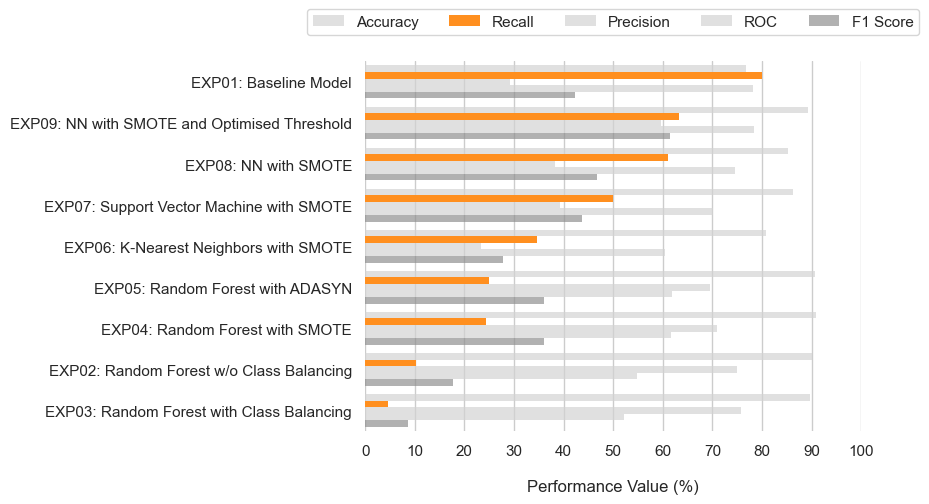

In [23]:
results_sorted = results_3.sort_values(by='Recall', ascending=False)
results_sorted['ROC'] = results_sorted['ROC'].apply(lambda x: x*100)
results_sorted = results_sorted.drop('Threshold', axis=1)
melted_df = pd.melt(results_sorted, id_vars='Experiment', var_name='Metric', value_name='Value')
ax = sns.barplot(data=melted_df, x='Value', y='Experiment', hue='Metric', dodge=True, linewidth=0)

sns.set(style='whitegrid')
#plt.figure(figsize=(10, 6))
colors = {'Accuracy': 'lightgrey', 'Recall': '#FF8F1F', 'Precision': 'lightgrey', 'ROC': 'lightgrey', 'F1 Score': '#909090'}

for metric, color in colors.items():
    for bar in ax.containers:
        if metric in bar.get_label():
            for rect in bar:
                alpha = 0.7 if metric != 'Recall' else 1.0
                for rect in bar:
                    rect.set_color(color)
                    rect.set_alpha(alpha)

plt.xlabel('Performance Value (%)', labelpad=15)
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.xticks(np.arange(0, 101, 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()